# **Jupyter Notebook for GCR**
</br>

## **Table of Content**

>### 0. Introduction
>### 1. 환경 구성
>### 2. Train Workflow
>### 3. Inference Workflow
>### 4. Batch Running
>### 5. 문의 및 기능 개발 요청
>### 6. References   

<br>

## **0. Introduction**

#### 본 sample notebook은 GCR의 구조와 각 asset의 역할과 산출물, 그 사용법을 처음 접하는 분들이 알기 쉽게 이해할 수 있도록 제작되었습니다.   

[ **1. 환경 구성** ]에서는 ALO 등 환경 설치 방법을 설명하고,   
[ **2. Train workflow** ]와 [ **3. Inference workflow** ]는 각각 train workflow와 inference workflow의 사용 방법과 산출물을 설명하며,   
[ **4. Batch running** ]에서는 sample notebook이 아닌 실제 과제 운용 시에 GCR contents를 수행하는 방법을 설명하고   
[ **5. 문의 및 기능 개발 요청** ]에서는 사용 중 문의 사항이나 기능에 대한 수정/개발 요청 방법을,   
[ **6. References** ]에서는 추가로 참고하실 collab 문서 등에 대한 links를 제공합니다.

#### Notebook의 Workflow는 다음과 같이 구성됩니다.
> Workflow NAME (ex. Train Workflow)

>> Workflow 구성 설명
>>> **A** asset : A asset 설명   
>>> **B** asset : B asset 설명   
>>> ...

>> Workflow Setup 
>>> Workflow Setup 코드

>> [0] **A** asset
>>> parameter 설명 및 실행 코드 

>> [1] **B** asset
>>> parameter 설명 및 실행 코드

>> ..

</br>

#### 각 Asset은 동작확인을 위해 다음과 같이 구성됩니다.
> ASSET NAME

>> 주요 Parameter 설명
>>> param1: param1 설명   
>>> ***param2***: param2 설명 [*option1 / option2 / option3*]   
>>> param3: param3 설명 [*option1 / option2*]   
>>> ..

>> Parameter 설정부
>>> #################   
>>> parameter 설정 코드   
>>> #################   

>> Asset 실행부
>>> #################   
>>> Asset 실행 코드   
>>> #################   

Asset 별로 experimental_plan.yaml에 주어진 parameter에 대한 설명이 주어집니다.   
설명에 따라 parameter 변경 시 experimental_plan.yaml을 직접 수정하거나, Parameter 설정부에서 코드 실행을 통해 바꿀 수 있습니다.   
위에서 param2와 같이 ***Bold Italic***으로 표기된 변수는 필수 설정 변수로, 최초 실행 또는 데이터가 바뀔 시 꼭 다시 설정해주어야 하는 변수를 의미합니다.   
설정된 parameter로 asset을 실행할 수 있습니다. 또한 Parameter를 변경해가며 Asset 실행 결과 변화를 관찰할 수 있습니다.

</br>

## **1. 환경 구성**

#### GCR을 사용하기 위해서는 아래와 같은 방법으로 데이터를 준비해야 합니다.
> 1. Train, Inference 두 개의 데이터셋을 준비합니다.
> 2. 각 데이터에 FLAG_TRAIN_INFERENCE 컬럼을 추가합니다. 
>    - 각 'Train', 'Inference'가 flag로 들어가야 합니다.
> 3. 두 데이터를 합쳐 하나의 데이터셋으로 구성합니다.

***GCR은 결측치와 범주형 데이터에 대한 전처리가 필요하지 않습니다***

#### ALO 설치 및 configuration 설정 방법은 다음과 같습니다.

1. 최상위 디렉토리에서 install.sh를 실행합니다
> source install.sh
2. install.sh를 실행하면 alo 디렉토리가 설치됩니다.
3. 가상환경을 설치 및 실행합니다.
> conda create -n gcr python=3.10   
> conda init bash   
> conda activate gcr    
3. alo/config 디렉토리로 이동하여 experimental_plan.yaml 파일을 오픈합니다.
4. external_path의 load_train_data_path에 아래와 같이 사용할 데이터의 경로(디렉토리)를 입력합니다.

>```
>external_path:
>    - load_train_data_path: /nas001/gcr_test_data/sample/
>    - load_inference_data_path:
>    - save_train_artifacts_path:
>    - save_inference_artifacts_path:
>```

5. 필수 변경 parameter를 변경합니다. 나머지 parameter는 컨텐츠 yaml에 제공된 default 값을 사용해도 괜찮습니다.
6. 아래 **ALO Setup**을 실행합니다.

### ALO Setup
라이브러리 설치 및 컨텐츠 다운로드를 위해 아래 코드를 실행 해주세요

In [1]:
import argparse
import time
import os
import copy

os.chdir(os.path.abspath(os.path.join('./alo')))
from src.alo import ALO
from src.alo import AssetStructure
alo = ALO(); alo.preset(); pipelines = list(alo.asset_source.keys())
from src.external import external_load_data, external_save_artifacts

def run(step, pipeline, asset_structure):
    # 반복되는 작업을 함수로 변환
    asset_config = alo.asset_source[pipeline]
    return alo.process_asset_step(asset_config[step], step, pipeline, asset_structure)

[2023-11-17 06:31:54,605][PROCESS][INFO]: Success versioning up experimental_plan.yaml : 2.0 --> 2.1 (version ref. : compare yaml version)


## **2. Train Workflow**

#### GCR의 Train Workflow 구성은 다음과 같습니다.
> **[0]** Input asset : *사용자가 지정한 경로로부터 데이터를 Import*   
> **[1]** Graph asset : *데이터를 토대로 그래프를 구성하고 필요한 임베딩 추출*   
> **[2]** Preprocess asset : *(필요시) 결측치 처리 및 라벨 인코딩*   
> **[3]** Sampling asset : *(필요시) Imbalance 데이터의 Undersampling*   
> **[4]** Train asset : *ML 모델 학습*

#### Train Workflow Setup
아래 코드를 실행하여 Train Workflow에 필요한 라이브러리를 먼저 설치 해주세요.

In [2]:
external_load_data(pipelines[0], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[0]
alo.install_steps(pipeline, alo.control["get_asset_source"])

# 초기 data structure 구성
envs, args, data, config = {}, {}, {}, {}
init_asset_structure = AssetStructure(envs, args, data, config)
# logger init
alo.set_proc_logger()

[2023-11-17 06:31:55,903][PROCESS][INFO]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY >> in your os environment. 

[2023-11-17 06:31:55,951][PROCESS][INFO]:  Skip loading external data. << /nas001/users/seongwoo.kong/gcr_test_data/sample/ >> 
 << sample >> already exists in << /home/jovyan/gcr/alo/input/train/ >>. 
 & << get_external_data >> is set as << once >>. 

[2023-11-17 06:31:55,954][PROCESS][INFO]: Start setting-up << input >> asset @ << assets >> directory.
[2023-11-17 06:31:55,967][PROCESS][INFO]: << input >> asset had already been created at 2023-11-16 02:04:56.709955
[2023-11-17 06:31:55,970][PROCESS][INFO]: Start setting-up << graph >> asset @ << assets >> directory.
[2023-11-17 06:31:55,987][PROCESS][INFO]: << graph >> asset had already been created at 2023-11-16 02:04:29.8

  You can safely remove it manually.
  You can safely remove it manually.


[2023-11-17 06:32:13,767][PROCESS][INFO]: ======================================== Finish dependency installation 



### [0] Input asset

#### 주요 Parameter
- ***input_path*** : Extenal Path에서 받은 데이터는 *alo/input/train*에 저장됩니다. 이 중에서 사용할 데이터가 저장된 디렉터리 명을 작성해주시면 됩니다.
- x_columns : 데이터의 모든 컬럼을 활용하지 않는 경우엔 직접 선택해서 사용할 수 있습니다.
- use_all_x : 데이터의 모든 컬럼을 사용하는 경우 True로 설정하고 사용합니다. 이 경우 x_columns는 빈칸이어야 합니다. [*True / False*]
- ***y_column*** : Classification, Regression을 위해서는 Label이 있어야 합니다. Label에 해당하는 컬럼을 작성합니다.
- groupkey_columns : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.
- drop_columns : use_all_x가 True일 때 삭제하고 싶은 컬럼을 입력합니다.
- time_column : 데이터에 시간 컬럼이 있을 경우 입력합니다.
- concat_dataframes : 같은 형태 csv 파일 여러 개를 input data로 불러올 시, concat 여부를 선택합니다. [*True / False*]
- encoding : pd.read_csv() 시에 사용할 encoding 방법을 설정합니다.

#### Parameter 설정

In [3]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 0 
asset_structure = copy.deepcopy(init_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다. 
#asset_structure.args['x_columns'] = ['']
asset_structure.args

{'input_path': 'sample',
 'x_columns': None,
 'use_all_x': True,
 'y_column': 'is_married',
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

#### Input asset 실행 

In [4]:
input_asset_structure=run(step, pipeline, asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다. 
input_asset_structure.data['dataframe'].head(10)

[2023-11-17 06:32:15,204][USER][INFO][train_pipeline][input]: >> Load path : ['/home/jovyan/gcr/alo/input/train/sample/']
[2023-11-17 06:32:15,233][USER][INFO][train_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/gcr/alo/input/train/sample/customers.csv)
[2023-11-17 06:32:15,236][USER][INFO][train_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2023-11-17 06:32:15,240][USER][INFO][train_pipeline][input]: ==================== Success loading dataframe ====================
[2023-11-17 06:32:15,243][USER][INFO][train_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/gcr/alo/input/train/sample/customers.csv']
[2023-11-17 06:32:15,247][USER][INFO][train_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['gender', 'FLAG_TRAIN_INFERENCE', 'hobbies', 'spent', 'name', 'add

[2023-11-17 06:32:15,199][ASSET][INFO][train_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:32:15
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2023-11-17 06:32:15,248][ASSET][INFO][train_pipeline][input]: 

============================= ASSET FINISH ==============

,name,address,gender,age,orders,spent,job,hobbies,is_married,FLAG_TRAIN_INFERENCE
0,Jasmine_Young,TN17745,female,80,0,233.44,Receptionist,Photography,False,TRAIN
1,Jeffery_Robinson,CT69980,male,42,15,264.70,Teacher,Fishing,True,TRAIN
2,Steven_Sullivan,CT13314,male,70,13,339.10,Janitor,Hiking,False,TRAIN
3,Jay_Williams,TN68283,male,27,7,70.61,Waitress,Playing musical instruments,False,TRAIN
4,Benjamin_Beck,AE11377,male,21,9,748.94,Farmer,Playing sports,True,TRAIN
5,Gregory_Gomez,FM04887,male,75,10,937.97,Unkown,Running,False,TRAIN
6,Mary_Harris,KS55063,female,60,12,60.97,Librarian,Reading,True,TRAIN
7,Jimmy_Smith,AL47190,male,72,5,468.64,Waitress,Sewing,False,TRAIN
8,Kenneth_Rubio,RI07301,male,74,15,482.72,Polic,Dancing,True,TRAIN
9,Jordan_Simmons,AA06497,female,41,1,156.16,Cashier,Baking,False,TRAIN


### [1] Graph asset

GCR의 가장 핵심이 되는 asset입니다. Raw Data를 임베딩으로 모두 변환하여 별도의 전처리 없이 더 높은 성능의 ML모델을 획득하기 위한 Tool이 됩니다.
#### 주요 Parameter
- graph_type : 그래프의 구조를 선택할 수 있습니다. radial은 방사형 구조, relational은 관계형 구조입니다. [*radial / relational*]
- center_node_column : 방사형 그래프는 중심 컬럼을 기준으로 그래프를 구성합니다. 데이터의 대표가 되는 컬럼을 선택하면 됩니다.(ex. ID, Name 등)
- embedding_column : 임베딩의 대상이 되는 컬럼을 선택합니다. 라벨이 center_node_column과 대응하지 않는 경우가 있을 수 있습니다. 이때는 label이 대응하는 컬럼을 embedding column으로 설정합니다.
- drop_columns : 그래프 구성에서 제외할 컬럼을 선택합니다.
- num_epochs: Embedding 학습을 위한 epoch을 설정합니다.
- workers : worker process 수를 설정합니다.
- num_partitions : partition 수를 설정합니다. 증가시켜 메모리 사용량을 줄일 수 있습니다.
- extra_columns_for_ml : ml 모델 학습에 임베딩 외에 사용될 컬럼을 지정합니다. 도메인 지식에 기반하여 선택할 필요가 있습니다.
- custom_connection : 그래프를 활용할 줄 안다면 직접 relation을 정의할 수 있습니다. 자세한 내용은 manual을 참고.

#### Parameter 설정

In [5]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 1 
asset_structure = copy.deepcopy(input_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 graph asset argument를 원하는 값으로 수정합니다. 
asset_structure.args['dimension'] = 128
asset_structure.args

{'graph_type': None,
 'center_node_column': 'name',
 'embedding_column': None,
 'train_inference_column': None,
 'drop_columns': [],
 'dimension': 128,
 'num_epochs': None,
 'workers': None,
 'num_partitions': None,
 'extra_columns_for_ml': [],
 'custom_connection': []}

#### Graph asset 실행 

In [6]:
# asset 실행
graph_asset_structure=run(step, pipeline, asset_structure)

# graph asset의 결과 dataframe은 graph_asset_structure.data['dataframe']으로 확인할 수 있습니다. 
graph_asset_structure.data['dataframe'].head(10)

[2023-11-17 06:32:19,941][ASSET][INFO][train_pipeline][graph]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo/.train_artifacts/output/graph/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2023-11-17 06:32:19,944][ASSET][INFO][train_pipeline][graph]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:32:19
- current step      : graph
- asset branch.     : release-1.2
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['graph_type', 'center_node_column', 'embedding_c

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torchbiggraph/util.py:222: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage_type()._new_shared(size.numel())
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:959: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if self.device.type not in ['cpu', 'cuda']:
/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/torch/storage.py:962: UserWarning: TypedStorage is deprecated. It will be removed in the future and Unty

[Embedding Complete]
[Embeddig result saved at /home/jovyan/gcr/alo/.train_artifacts/output/graph/RESULT]
[2023-11-17 06:32:59,163][ASSET][INFO][train_pipeline][graph]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo/.train_artifacts/models/graph/
In __del__: pbg deleted
[2023-11-17 06:32:59,211][ASSET][INFO][train_pipeline][graph]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-17 06:32:59
- current step      : graph
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns'])
- save data keys    : dict_keys(['dataframe'])


[2023-11-17 06:32:59,218][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: graph


,name,is_married,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,...,EMB_118,EMB_119,EMB_120,EMB_121,EMB_122,EMB_123,EMB_124,EMB_125,EMB_126,EMB_127
0,Jasmine_Young,False,0.024974,0.007638,-0.004251,0.002464,0.015333,-0.004593,-0.011245,-0.022816,...,-0.004635,0.006578,-0.018206,0.001426,-0.007354,0.008252,0.008084,-0.009249,0.014574,-0.001155
1,Jeffery_Robinson,True,-0.008449,-0.007763,-0.022430,0.008236,-0.001891,0.000767,0.009380,0.006806,...,0.015006,-0.005936,0.001356,-0.009295,0.011241,-0.007399,-0.019122,0.009324,-0.034060,-0.019440
2,Steven_Sullivan,False,-0.019424,0.007726,0.012575,-0.001292,0.006189,0.012953,0.008530,0.002165,...,0.006618,0.006113,0.008421,-0.004329,0.014880,-0.003377,-0.010354,0.009553,-0.015781,-0.001166
3,Jay_Williams,False,-0.010120,-0.009104,-0.015809,0.001753,-0.015064,-0.003561,0.000679,-0.004213,...,0.003262,-0.004391,0.023065,0.006224,0.020297,-0.009825,-0.021217,-0.006951,0.004516,-0.010117
4,Benjamin_Beck,True,-0.009757,-0.008288,0.011543,-0.002391,0.010626,-0.006650,-0.023285,0.008229,...,0.004394,-0.035844,-0.005745,0.013526,0.000501,-0.022697,-0.011086,-0.000214,-0.030524,-0.001854
5,Gregory_Gomez,False,-0.011007,0.011702,0.010162,0.003859,-0.005959,-0.011005,0.005286,-0.017144,...,0.006860,-0.020605,0.013268,0.003548,0.025282,-0.014628,0.000838,0.024624,0.000534,-0.003882
6,Mary_Harris,True,-0.003335,-0.008783,0.001342,-0.023075,0.003709,0.011911,0.000960,-0.013779,...,-0.022717,0.016143,-0.002019,-0.001472,0.009565,0.012271,-0.003367,-0.015318,0.010930,0.015784
7,Jimmy_Smith,False,-0.006352,-0.019224,-0.037491,-0.002359,-0.020693,-0.006890,0.008439,0.012539,...,-0.004563,-0.019579,0.011839,0.012159,0.005548,-0.008609,-0.017191,-0.001574,-0.010521,-0.012327
8,Kenneth_Rubio,True,-0.025676,0.000930,-0.016240,0.003634,0.002559,0.003469,-0.001965,0.026829,...,0.012854,-0.021040,0.021807,0.004527,0.010248,-0.008834,-0.015866,-0.017164,-0.003658,-0.006843
9,Jordan_Simmons,False,-0.006510,0.005137,0.007197,-0.006148,-0.017680,0.004268,0.009188,0.015250,...,-0.009158,0.014449,-0.021523,-0.000791,0.008259,-0.013100,0.011254,0.015127,0.005240,-0.015437


### [2] Preprocess asset 

GCR은 데이터 전처리가 불필요하기 때문에 Preprocess asset의 역할은 크지 않습니다. 다만 사용자가 임베딩 외에 raw data를 학습에 사용하는 경우 (즉, extra_columns_for_ml 설정시) 결측치를 처리하기 위한 용도입니다.
#### 주요 Parameter
- handling_missing : 결측치 처리 방식을 지정합니다. 'interpolation' 또는 'fill_number' 중에 선택할 수 있으며 GCR에서는 'interpolation'을 권장합니다.
- ***handling_encoding_y_column*** : input asset의 y_column과 동일하게 설정합니다. (필수)
- ***handling_encoding_y*** : y_column의 인코딩 방식을 설정합니다. GCR에서는 'label'로 설정합니다.
- handling_scaling_x : X 컬럼의 scaling 방식을 선택합니다.
- load_train_preprocess : False로 설정합니다. (inference workflow 전용)

#### Parameter 설정

In [7]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 2 
asset_structure = copy.deepcopy(graph_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['handling_missing'] = dropna
asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': 'is_married',
 'handling_encoding_y': 'label',
 'handling_scaling_x': 'none',
 'load_train_preprocess': False}

#### Preprocess asset 실행 

In [8]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2023-11-17 06:33:01,546][ASSET][INFO][train_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo/.train_artifacts/models/preprocess/
[2023-11-17 06:33:01,548][ASSET][INFO][train_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:33:01
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'handling_encoding_y', 'handling_scaling_x', 'load_train_preprocess'])
- l

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_119_nan,EMB_120_nan,EMB_121_nan,EMB_122_nan,EMB_123_nan,EMB_124_nan,EMB_125_nan,EMB_126_nan,EMB_127_nan,is_married_encoded_nan
0,0.024974,0.007638,-0.004251,0.002464,0.015333,-0.004593,-0.011245,-0.022816,-0.007108,0.019167,...,0.006578,-0.018206,0.001426,-0.007354,0.008252,0.008084,-0.009249,0.014574,-0.001155,0
1,-0.008449,-0.007763,-0.022430,0.008236,-0.001891,0.000767,0.009380,0.006806,-0.004699,-0.011067,...,-0.005936,0.001356,-0.009295,0.011241,-0.007399,-0.019122,0.009324,-0.034060,-0.019440,1
2,-0.019424,0.007726,0.012575,-0.001292,0.006189,0.012953,0.008530,0.002165,0.008563,-0.012499,...,0.006113,0.008421,-0.004329,0.014880,-0.003377,-0.010354,0.009553,-0.015781,-0.001166,0
3,-0.010120,-0.009104,-0.015809,0.001753,-0.015064,-0.003561,0.000679,-0.004213,0.010689,-0.008654,...,-0.004391,0.023065,0.006224,0.020297,-0.009825,-0.021217,-0.006951,0.004516,-0.010117,0
4,-0.009757,-0.008288,0.011543,-0.002391,0.010626,-0.006650,-0.023285,0.008229,0.007657,-0.008563,...,-0.035844,-0.005745,0.013526,0.000501,-0.022697,-0.011086,-0.000214,-0.030524,-0.001854,1
5,-0.011007,0.011702,0.010162,0.003859,-0.005959,-0.011005,0.005286,-0.017144,-0.000583,-0.000018,...,-0.020605,0.013268,0.003548,0.025282,-0.014628,0.000838,0.024624,0.000534,-0.003882,0
6,-0.003335,-0.008783,0.001342,-0.023075,0.003709,0.011911,0.000960,-0.013779,-0.015822,-0.008788,...,0.016143,-0.002019,-0.001472,0.009565,0.012271,-0.003367,-0.015318,0.010930,0.015784,1
7,-0.006352,-0.019224,-0.037491,-0.002359,-0.020693,-0.006890,0.008439,0.012539,0.016908,-0.011289,...,-0.019579,0.011839,0.012159,0.005548,-0.008609,-0.017191,-0.001574,-0.010521,-0.012327,0
8,-0.025676,0.000930,-0.016240,0.003634,0.002559,0.003469,-0.001965,0.026829,0.004360,-0.016075,...,-0.021040,0.021807,0.004527,0.010248,-0.008834,-0.015866,-0.017164,-0.003658,-0.006843,1
9,-0.006510,0.005137,0.007197,-0.006148,-0.017680,0.004268,0.009188,0.015250,0.002683,0.015016,...,0.014449,-0.021523,-0.000791,0.008259,-0.013100,0.011254,0.015127,0.005240,-0.015437,0


### [3] Sampling asset  

데이터 imbalance가 심한경우엔 sampling이 필요할 수 있습니다. 현재는 undersampling만 제공됩니다.
#### 주요 Parameter
- sampling_type : sampling이 필요한 경우 설정합니다. 필요없는 경우엔 'none'으로 설정합니다. [*none / under*]
- sampling_method : sampling 방법을 선택합니다. [*random / cluster / negative*]
- label_sampling : 데이터의 Y 라벨을 기준으로 데이터를 그룹핑하여 샘플링을 할 지 선택합니다. [*True / False*]
- ignore_label_class : label_sampling이 True일 때, 라벨의 특정 클래스는 샘플링하지 않고 전부 사용하고 싶을 때 사용합니다. EX) Y 라벨 클래스가 'OK' 또는 'NG'일 때 'NG'클래스를 입력할 경우 NG클래스는 샘플링하지 않습니다.
- negative_target_class : Negative sampling(sampling_method가 negative일 때)에만 사용되는 argument입니다. 기준이 되는 Y 라벨의 특정 클래스를 기입합니다.
- label_sampling_num_type : Y 라벨의 각 클래스에 샘플링할 데이터 수를 계산하기 위한 방법들입니다. [*ratio / number / compare / mingroup*]
- label_sampling_num : label_sampilng_num_type에 따라 값을 입력합니다. (user manual 참조)
- sampling_groupkey_columns : 특정 컬럼을 기준으로 데이터를 그룹핑하여 샘플링을 할 때 사용합니다. 컬럼명을 list로 입력합니다.
- sampling_num_type : 샘플링할 데이터 수를 결정하는 방법입니다. [*ratio / number / compare / mingroup*]
- sampling_num : sampling_num_type에 따라 아래 예시의 형식으로 값을 입력합니다. (user manual 참조)

#### Parameter 설정

In [9]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 3 
asset_structure = copy.deepcopy(preprocess_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 sampling asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['sampling_type'] = 'under'
asset_structure.args

{'sampling_type': 'none',
 'sampling_method': 'negative',
 'label_sampling': True,
 'ignore_label_class': 1,
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {1: 1, 0: 25},
 'sampling_groupkey_columns': None,
 'sampling_num_type': None,
 'sampling_num': None}

#### Sampling asset 실행 

In [10]:
# asset 실행
sampling_asset_structure=run(step, pipeline, asset_structure)

# sampling asset의 결과 dataframe은 sampling_asset_structure.data['dataframe']으로 확인할 수 있습니다.
sampling_asset_structure.data['dataframe'].head(10)

/home/jovyan/conda/envs/gcr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-17 06:33:12,476][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:33:12
- current step      : sampling
- asset branch.     : release-1.2
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['sampling_type', 'sampling_method', 'label_sampling', 'ignore_label_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns',

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_119_nan,EMB_120_nan,EMB_121_nan,EMB_122_nan,EMB_123_nan,EMB_124_nan,EMB_125_nan,EMB_126_nan,EMB_127_nan,is_married_encoded_nan
0,0.024974,0.007638,-0.004251,0.002464,0.015333,-0.004593,-0.011245,-0.022816,-0.007108,0.019167,...,0.006578,-0.018206,0.001426,-0.007354,0.008252,0.008084,-0.009249,0.014574,-0.001155,0
1,-0.008449,-0.007763,-0.022430,0.008236,-0.001891,0.000767,0.009380,0.006806,-0.004699,-0.011067,...,-0.005936,0.001356,-0.009295,0.011241,-0.007399,-0.019122,0.009324,-0.034060,-0.019440,1
2,-0.019424,0.007726,0.012575,-0.001292,0.006189,0.012953,0.008530,0.002165,0.008563,-0.012499,...,0.006113,0.008421,-0.004329,0.014880,-0.003377,-0.010354,0.009553,-0.015781,-0.001166,0
3,-0.010120,-0.009104,-0.015809,0.001753,-0.015064,-0.003561,0.000679,-0.004213,0.010689,-0.008654,...,-0.004391,0.023065,0.006224,0.020297,-0.009825,-0.021217,-0.006951,0.004516,-0.010117,0
4,-0.009757,-0.008288,0.011543,-0.002391,0.010626,-0.006650,-0.023285,0.008229,0.007657,-0.008563,...,-0.035844,-0.005745,0.013526,0.000501,-0.022697,-0.011086,-0.000214,-0.030524,-0.001854,1
5,-0.011007,0.011702,0.010162,0.003859,-0.005959,-0.011005,0.005286,-0.017144,-0.000583,-0.000018,...,-0.020605,0.013268,0.003548,0.025282,-0.014628,0.000838,0.024624,0.000534,-0.003882,0
6,-0.003335,-0.008783,0.001342,-0.023075,0.003709,0.011911,0.000960,-0.013779,-0.015822,-0.008788,...,0.016143,-0.002019,-0.001472,0.009565,0.012271,-0.003367,-0.015318,0.010930,0.015784,1
7,-0.006352,-0.019224,-0.037491,-0.002359,-0.020693,-0.006890,0.008439,0.012539,0.016908,-0.011289,...,-0.019579,0.011839,0.012159,0.005548,-0.008609,-0.017191,-0.001574,-0.010521,-0.012327,0
8,-0.025676,0.000930,-0.016240,0.003634,0.002559,0.003469,-0.001965,0.026829,0.004360,-0.016075,...,-0.021040,0.021807,0.004527,0.010248,-0.008834,-0.015866,-0.017164,-0.003658,-0.006843,1
9,-0.006510,0.005137,0.007197,-0.006148,-0.017680,0.004268,0.009188,0.015250,0.002683,0.015016,...,0.014449,-0.021523,-0.000791,0.008259,-0.013100,0.011254,0.015127,0.005240,-0.015437,0


### [4] Train asset

추출된 임베딩을 활용하여 ML모델을 학습합니다.
#### 주요 Parameter
- model_type: 목적에 맞는 학습 방식을 선택합니다. (classification/regression)
- data_split_method: HPO를 위한 데이터 분할 방식을 선택합니다. (cross_validate/train_test_split)
- evaluation_metric: classification의 경우 accuracy, precision, recall, f1-score / regression의 경우 mse, r2, mae, rmse 중 선택합니다.
- model_list: lightgbm, random-forest, gbm, Catboost 중 복수 선택 가능합니다.
- num_hpo: 설정 범위 내 hpo 횟수를 결정합니다.
- param_range: Search 범위를 지정합니다.
- shap_ratio: shap value 뽑을 데이터를 sampling 하는 비율을 결정합니다.

#### Parameter 설정

In [11]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 4 
asset_structure = copy.deepcopy(sampling_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 train asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['num_hpo'] = 1
asset_structure.args

{'model_type': 'classification',
 'data_split_method': 'cross_validate',
 'evaluation_metric': 'accuracy',
 'model_list': ['lgb', 'rf', 'cb'],
 'num_hpo': 3,
 'param_range': {'rf': {'max_depth': 6, 'n_estimators': [300, 500]},
  'gbm': {'max_depth': [5, 7], 'n_estimators': [300, 500]},
  'ngb': {'col_sample': [0.6, 0.8], 'n_estimators': [100, 300]},
  'lgb': {'max_depth': [5, 9], 'n_estimators': [300, 500]},
  'cb': {'max_depth': [5, 9], 'n_estimators': [100, 500]}},
 'shap_ratio': 1.0}

#### Train asset 실행 

[2023-11-17 06:33:13,422][ASSET][INFO][train_pipeline][train]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo/.train_artifacts/models/train/
[2023-11-17 06:33:13,426][ASSET][INFO][train_pipeline][train]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr/alo/.train_artifacts/output/train/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2023-11-17 06:33:13,428][ASSET][INFO][train_pipeline][train]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:33:13
- current step      : train
- asset branch.     : tcr_v1.1.2
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_arti


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] 0th-fold RandomForestClassifier_set0 모델을 학습합니다.(1/36)
[INFO] 1th-fold RandomForestClassifier_set0 모델을 학습합니다.(2/36)
[INFO] 2th-fold RandomForestClassifier_set0 모델을 학습합니다.(3/36)
[INFO] 3th-fold RandomForestClassifier_set0 모델을 학습합니다.(4/36)
[INFO] 0th-fold RandomForestClassifier_set1 모델을 학습합니다.(5/36)
[INFO] 1th-fold RandomForestClassifier_set1 모델을 학습합니다.(6/36)
[INFO] 2th-fold RandomForestClassifier_set1 모델을 학습합니다.(7/36)
[INFO] 3th-fold RandomForestClassifier_set1 모델을 학습합니다.(8/36)
[INFO] 0th-fold RandomForestClassifier_set2 모델을 학습합니다.(9/36)
[INFO] 1th-fold RandomForestClassifier_set2 모델을 학습합니다.(10/36)
[INFO] 2th-fold RandomForestClassifier_set2 모델을 학습합니다.(11/36)
[INFO] 3th-fold RandomForestClassifier_set2 모델을 학습합니다.(12/36)
[INFO] 0th-fold LGBMClassifier_set0 모델을 학습합니다.(13/36)
[INFO] 1th-fold LGBMClassifier_set0 모델을 학습합니다.(14/36)
[INFO] 2th-fold LGBMClassifier_set0 모델을 학습합니다.(15/36)
[INFO] 3th-fold LGBMClassifier_set0 모델을 학습합니다.(16/36)
[INFO] 0th-fold LGBMClassifier_set1 모델을 학습합니다.(17

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/gcr/alo/.train_artifacts/models/train/model_selection.json)

Top 1 model file is saved: /home/jovyan/gcr/alo/.train_artifacts/models/train/best_model_top0.pkl
[Score] accuracy: 0.7077
[Hyper-parameters] n_estimators: 300, n_jobs: 1, random_state: 1234, max_depth: 6, 

Top 2 model file is saved: /home/jovyan/gcr/alo/.train_artifacts/models/train/best_model_top1.pkl
[Score] accuracy: 0.7077
[Hyper-parameters] max_depth: 7, n_estimators: 300, verbose: 0, random_state: 1234, thread_count: 6, allow_writing_files: False, 

Top 3 model file is saved: /home/jovyan/gcr/alo/.train_artifacts/models/train/best_model_top2.pkl
[Score] accuracy: 0.7077
[Hyper-parameters] n_estimators: 400, n_jobs: 1, random_state: 1234, max_depth: 6, 

Following model is the best: RandomForestClassifier_set0 / accuracy:0.7077


[INFO] Summary_plot for Train data 를 저장했습니다.

ignore columns와 X로 지정한 데이터 프레임을 합치는 과정중에 에러가 발생했습니다. 확인 부탁드립니다.
[2023-1

,EMB_000_nan,EMB_001_nan,EMB_002_nan,EMB_003_nan,EMB_004_nan,EMB_005_nan,EMB_006_nan,EMB_007_nan,EMB_008_nan,EMB_009_nan,...,EMB_126_nan_shapley,EMB_127_nan_shapley,is_married_encoded_nan,pred_is_married_encoded_nan,pred_is_married_encoded_nan_best0,pred_is_married_encoded_nan_best1,pred_is_married_encoded_nan_best2,prob_0,prob_1,train_test
0,-0.011092,-0.007647,-0.004009,0.004060,-0.017412,-0.003755,-0.015752,0.011213,0.024591,-0.008447,...,0.001604,0.001301,0,0,0,0,0,0.778348,0.221652,0th_test
1,0.026522,-0.003607,-0.002386,-0.004075,0.027163,-0.003498,0.016953,0.000167,0.009661,0.007398,...,0.001852,0.000088,0,0,0,0,0,0.660790,0.339210,2th_test
2,0.006398,0.012297,-0.007344,-0.024922,0.000486,-0.008970,0.003872,0.013081,0.008850,-0.007655,...,0.002154,-0.001284,0,0,0,0,0,0.679557,0.320443,1th_test
3,0.002254,0.000630,-0.000583,0.016570,-0.008005,0.005667,-0.009199,0.000416,0.030139,0.001205,...,0.001181,0.002430,0,0,0,0,0,0.700551,0.299449,3th_test
4,0.002612,-0.000817,0.013548,-0.007850,0.013460,0.001660,-0.001412,-0.019718,-0.002209,0.019642,...,0.002363,0.000094,0,0,0,0,0,0.768134,0.231866,3th_test
5,0.000252,0.001450,-0.016618,-0.036875,-0.001627,-0.015449,0.011982,0.009726,0.014693,-0.017954,...,-0.052680,-0.000718,1,0,0,0,0,0.553131,0.446869,3th_test
6,0.037526,-0.027751,0.003812,-0.011613,0.039342,0.011726,0.009272,-0.002179,-0.015952,0.014562,...,-0.001457,-0.008923,1,0,0,0,0,0.628638,0.371362,3th_test
7,-0.015889,0.006197,-0.019163,0.012900,0.000633,0.006338,0.011664,-0.011931,0.011607,0.016894,...,-0.014218,-0.005555,1,0,0,0,0,0.719627,0.280373,3th_test
8,-0.011632,-0.006201,-0.012002,0.010641,-0.028381,0.013670,-0.003384,0.010842,-0.011445,-0.013768,...,-0.014613,0.001889,0,0,0,0,0,0.731925,0.268075,3th_test
9,-0.013859,-0.001645,-0.003628,0.021995,-0.034791,0.012426,0.000419,0.010285,-0.011974,-0.014407,...,0.001338,0.002251,0,0,0,0,0,0.756649,0.243351,2th_test


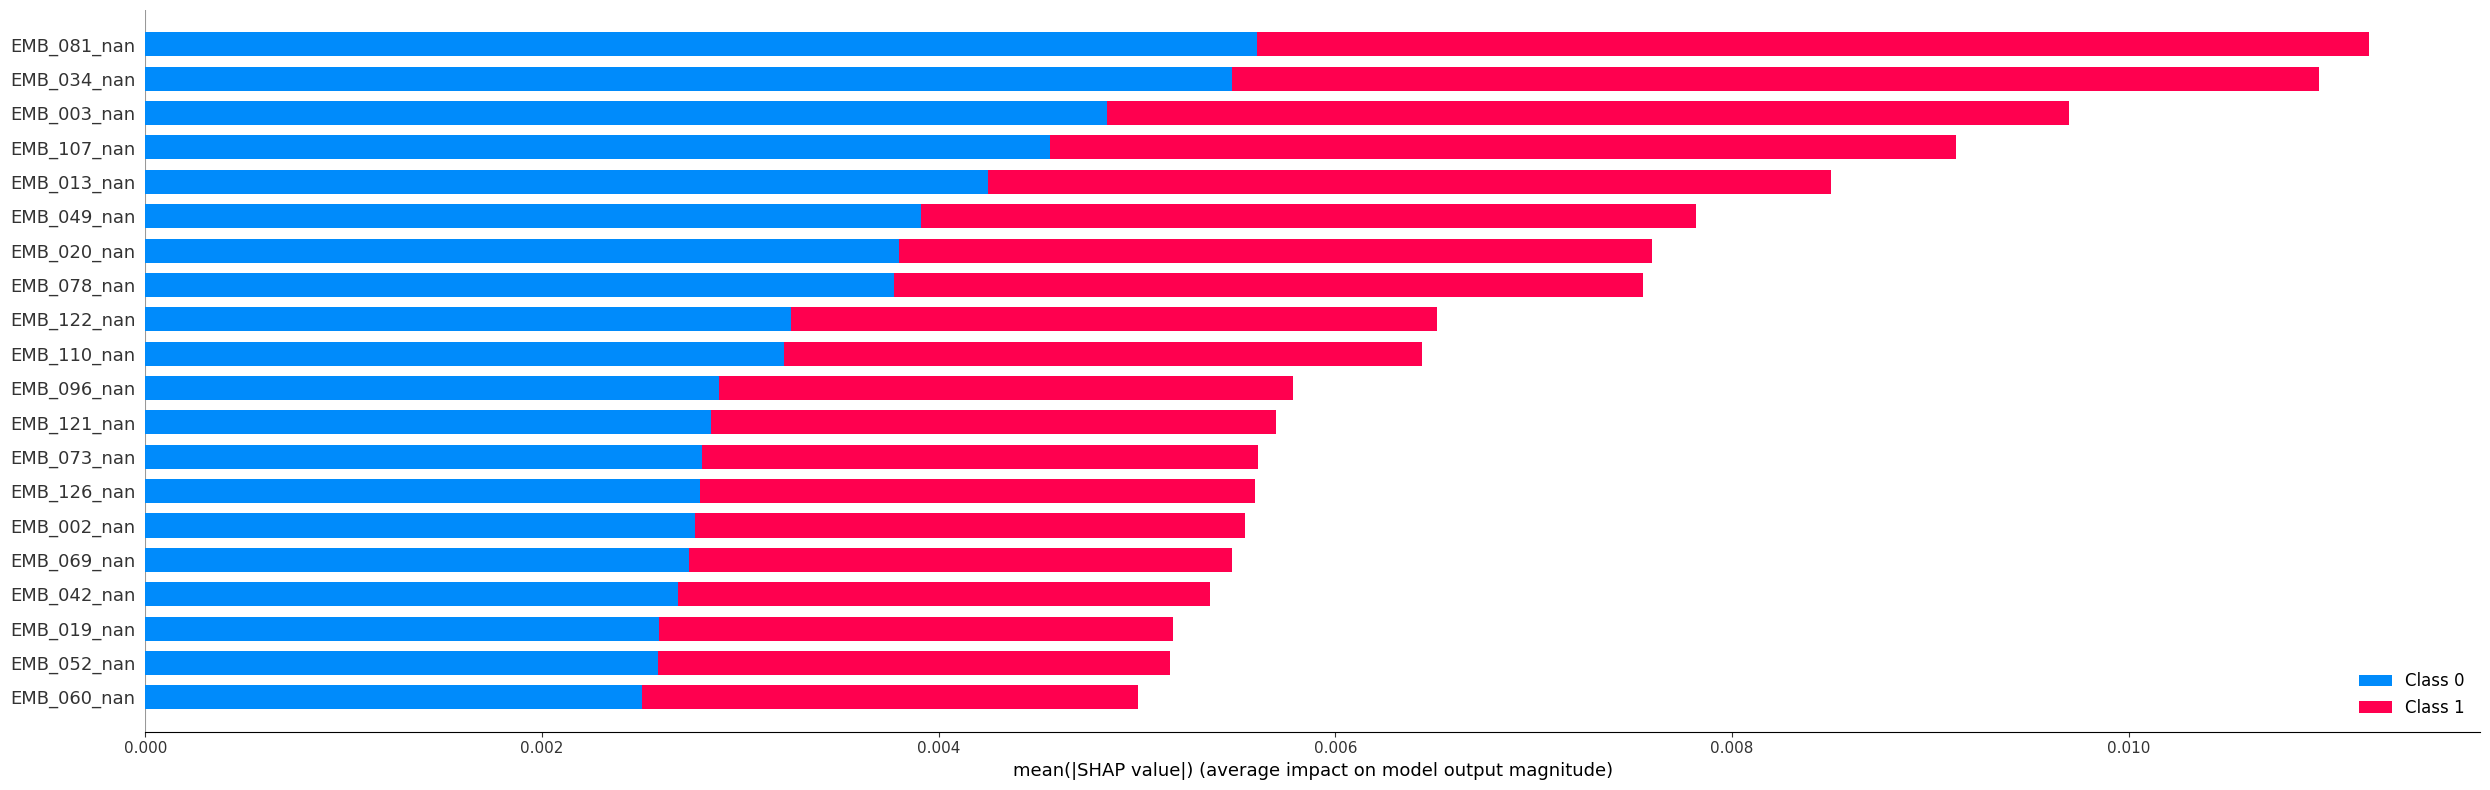

In [12]:
# asset 실행
train_asset_structure=run(step, pipeline, asset_structure)

# train asset의 결과 dataframe은 train_asset_structure.data['dataframe']으로 확인할 수 있습니다.
train_asset_structure.data['dataframe'].head(10)

## **3. Inference Workflow**

#### GCR의 Inference Workflow 구성은 다음과 같습니다.
> **[0]** Input : *사용자가 지정한 경로로부터 데이터를 Import*   
> **[1]** Preprocess : *(필요시) 결측치 처리 및 라벨 인코딩*   
> **[2]** Inference : *Train Workflow에서 선택된 베스트 모델을 활용해 라벨 추론*   
> **[3]** Result : *결과 출력*   


#### Train Workflow Setup
아래 코드를 실행하여 Train Workflow에 필요한 라이브러리를 먼저 설치 해주세요.

In [13]:
# 아래는 Inference 시 필요한 라이브러리를 설치하는 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 해주세요
external_load_data(pipelines[1], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[1]
alo.install_steps(pipeline, alo.control["get_asset_source"])

# 초기 data structure 구성
envs, args, data, config = {}, {}, {}, {}
init_asset_structure = AssetStructure(envs, args, data, config)
# logger init
alo.set_proc_logger()

[2023-11-17 06:36:22,463][PROCESS][INFO]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY >> in your os environment. 

[2023-11-17 06:36:22,468][PROCESS][INFO]: Start setting-up << input >> asset @ << assets >> directory.
[2023-11-17 06:36:22,472][PROCESS][INFO]: Now << local >> asset_source_code mode: <input> asset exists.
[2023-11-17 06:36:22,474][PROCESS][INFO]: Start setting-up << preprocess >> asset @ << assets >> directory.
[2023-11-17 06:36:22,477][PROCESS][INFO]: Now << local >> asset_source_code mode: <preprocess> asset exists.
[2023-11-17 06:36:22,479][PROCESS][INFO]: Start setting-up << inference >> asset @ << assets >> directory.
[2023-11-17 06:36:22,482][PROCESS][INFO]: Start renewing asset : /home/jovyan/gcr/alo/assets/inference
[2023-11-17 06:36:22,869][PROCESS][INFO]: /home/j

### [0] Input asset 

#### 주요 Parameter
- input_path : GCR에서는 추론데이터가 'inference' 위치에 자동 저장됩니다. 따로 설정할 필요 없이 주어진 'inference'로 놓고 사용합니다.
- x_columns : Inference workflow에서는 x_column을 따로 지정하지 않습니다. None으로 설정합니다.
- use_all_x : Inference workflow에서는 use_all_x를 True로 놓습니다.
- y_column : 추론데이터는 y_column이 없습니다. None으로 설정합니다.
- groupkey_columns : 특정 컬럼 명을 기준으로 데이터를 그룹으로 나누어 모델링을 하고 싶을 경우에 사용합니다.
- drop_columns : use_all_x가 True일 때 삭제하고 싶은 컬럼을 입력합니다.
- time_column : 데이터에 시간 컬럼이 있을 경우 입력합니다.
- concat_dataframes : 같은 형태 csv 파일 여러 개를 input data로 불러올 시, concat 여부를 선택합니다. [*True / False*]
- encoding : pd.read_csv() 시에 사용할 encoding 방법을 설정합니다.

#### Parameter 설정

In [14]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 0 
asset_structure = copy.deepcopy(init_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'input_path': 'inference',
 'x_columns': None,
 'use_all_x': True,
 'y_column': None,
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

##### Input asset 실행 

In [15]:
# asset 실행
input_asset_structure=run(step, pipeline, asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다.
input_asset_structure.data['dataframe'].head(10)

[2023-11-17 06:36:23,514][USER][INFO][inference_pipeline][input]: >> Load path : ['/home/jovyan/gcr/alo/input/inference/inference/']
[2023-11-17 06:36:23,529][USER][INFO][inference_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/gcr/alo/input/inference/inference/inference.csv)
[2023-11-17 06:36:23,532][USER][INFO][inference_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2023-11-17 06:36:23,535][USER][INFO][inference_pipeline][input]: ==================== Success loading dataframe ====================
[2023-11-17 06:36:23,538][USER][INFO][inference_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/gcr/alo/input/inference/inference/inference.csv']
[2023-11-17 06:36:23,542][USER][INFO][inference_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['EMB_031', 'EMB_104',

[2023-11-17 06:36:23,511][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:36:23
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2023-11-17 06:36:23,543][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET FINISH ======

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_118,EMB_119,EMB_120,EMB_121,EMB_122,EMB_123,EMB_124,EMB_125,EMB_126,EMB_127
0,-0.011211,0.021192,0.013510,0.010420,0.012326,0.010024,0.022406,-0.009880,0.006558,-0.014621,...,0.018959,-0.017662,0.022990,0.020000,-0.005146,-0.003938,-0.015009,0.019535,0.002308,-0.016103
1,0.008541,0.004134,-0.006659,-0.008561,-0.013276,-0.011484,0.001329,0.029092,0.010130,-0.020120,...,0.003465,-0.009100,0.012163,0.005579,-0.005517,0.005121,0.002899,-0.009514,0.002380,0.002756
2,0.019315,0.004849,-0.022684,0.012220,0.007098,0.011592,0.003066,-0.007337,-0.002128,0.004139,...,0.002843,0.013025,-0.014647,0.017651,-0.017356,0.013134,0.002680,0.001103,-0.003784,0.000100
3,0.013164,-0.009407,0.010454,-0.017179,0.021407,-0.004327,-0.006342,-0.009666,-0.005924,0.015952,...,0.019964,-0.013472,-0.006695,-0.011809,-0.010589,-0.001992,0.017462,0.000677,0.007710,0.016784
4,-0.008298,-0.003845,0.022752,0.004630,0.018120,-0.002713,-0.004593,-0.026710,-0.010649,0.020809,...,0.005280,0.009019,-0.013289,0.000041,-0.009036,0.000817,0.016854,-0.008670,0.015686,-0.012213
5,0.014745,-0.001136,0.002283,-0.010555,0.016204,0.015836,0.001790,0.023532,0.016864,-0.015578,...,-0.009099,0.013923,0.008759,-0.014268,-0.018184,0.024693,0.003871,0.011058,0.008464,0.024613
6,-0.031200,-0.008771,0.021719,0.036718,0.006874,-0.011510,-0.011052,0.013309,0.008968,0.010274,...,-0.000262,-0.018567,-0.022518,-0.010394,-0.013227,0.001842,-0.011835,-0.047739,0.007006,-0.005282
7,0.004072,0.024870,-0.015082,-0.001626,0.014011,0.003743,0.049421,0.006498,-0.016665,-0.039833,...,0.035174,-0.016693,0.042376,0.017134,0.013079,-0.016026,-0.021061,-0.014082,-0.005783,-0.009873
8,-0.020969,-0.003268,0.003840,0.008835,0.008807,-0.007809,0.004840,0.002440,0.017214,-0.011284,...,-0.035367,-0.018924,-0.013157,0.006886,-0.000217,0.009760,-0.007533,-0.011800,0.010786,-0.015307
9,0.012875,-0.005404,-0.025041,0.008551,-0.009934,-0.012423,-0.001929,-0.004785,0.002376,-0.020264,...,0.002861,-0.007941,-0.011732,0.004964,-0.006709,0.001475,-0.003956,-0.006232,-0.010216,-0.011842


### [1] Preprocess asset 

GCR은 데이터 전처리가 불필요하기 때문에 Preprocess asset의 역할은 크지 않습니다. 다만 사용자가 임베딩 외에 raw data를 학습에 사용하는 경우 (즉, extra_columns_for_ml 설정시) 결측치를 처리하기 위한 용도입니다.
#### 주요 Parameter
- handling_missing: 결측치 처리 방식을 지정합니다. 'interpolation' 또는 'fill_number' 중에 선택할 수 있으며 GCR에서는 'interpolation'을 권장합니다.
- ***handling_encoding_y_column***: input asset의 y_column과 동일하게 설정합니다. (필수)
- limit_encoding_categories: onehot이나 hashing 인코딩 진행 시 컬럼이 너무 많아지는 것에 대한 한계치를 설정합니다.
- load_train_preprocess: 반드시 True로 설정합니다. train workflow의 preprocess를 참조하여 진행합니다.

#### Parameter 설정

In [16]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 1 
asset_structure = copy.deepcopy(input_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': None,
 'limit_encoding_categories': 30,
 'load_train_preprocess': True}

#### Preprocess asset 실행 

In [17]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2023-11-17 06:36:23,585][ASSET][INFO][inference_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr/alo/.train_artifacts/models/preprocess/
[2023-11-17 06:36:23,588][ASSET][INFO][inference_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:36:23
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'limit_encoding_categories', 'load_train_preprocess'])
- load conf

,EMB_031,EMB_104,EMB_043,EMB_037,EMB_038,EMB_125,EMB_098,EMB_077,EMB_027,EMB_016,...,EMB_030_nan,EMB_090_nan,EMB_126_nan,EMB_018_nan,EMB_012_nan,EMB_064_nan,EMB_101_nan,EMB_033_nan,EMB_036_nan,EMB_092_nan
0,0.008525,0.011202,0.002951,-0.014495,0.038221,0.019535,0.006818,0.003573,0.029008,-0.001390,...,0.032742,0.005224,0.002308,-0.022976,0.025663,0.036108,-0.010685,-0.009478,-0.018460,-0.022039
1,0.011305,-0.002355,0.011688,0.001708,0.012991,-0.009514,0.000210,-0.000300,-0.004147,-0.017649,...,0.010245,0.014657,0.002380,-0.023908,-0.007041,0.005529,0.012320,0.006187,0.008182,-0.012942
2,-0.002716,-0.016088,-0.007759,0.012123,0.003149,0.001103,0.008807,0.015945,-0.008076,-0.011258,...,0.001252,-0.013325,-0.003784,0.003302,0.016016,0.002450,0.008070,-0.029511,0.010089,0.013205
3,0.018034,0.003324,-0.002535,0.025256,-0.001771,0.000677,-0.000827,-0.006499,-0.002078,-0.007425,...,0.007055,-0.012081,0.007710,-0.008706,0.003291,0.004677,0.028044,0.020258,-0.002945,-0.003443
4,-0.005031,-0.003910,-0.005302,0.009657,-0.002793,-0.008670,0.011824,0.012488,0.019366,-0.000175,...,0.004665,-0.013626,0.015686,-0.001067,0.009883,0.001509,0.002696,0.000680,0.006841,0.001502
5,-0.002576,-0.019350,0.001317,0.016711,-0.006706,0.011058,-0.000500,-0.002399,-0.038739,0.031725,...,0.029427,0.014949,0.008464,-0.012945,-0.021204,-0.015321,0.013478,0.010060,0.000286,-0.031791
6,0.000781,-0.016125,-0.001955,-0.008803,-0.007304,-0.047739,0.014152,-0.046066,-0.013409,-0.036250,...,0.028579,-0.005489,0.007006,-0.005084,0.018506,-0.010945,-0.019512,-0.002033,-0.004061,0.012846
7,0.011470,-0.024099,0.035796,-0.002648,0.017315,-0.014082,-0.003605,-0.016682,0.000704,-0.026923,...,0.005431,-0.007190,-0.005783,-0.022636,-0.026467,0.010841,0.006084,0.040247,0.005505,-0.013749
8,0.001083,-0.003770,0.013284,-0.021991,0.005800,-0.011800,0.010231,0.020301,0.004736,-0.008520,...,0.003203,-0.003019,0.010786,0.007349,0.010961,0.014701,0.000328,0.005039,0.004748,-0.001888
9,-0.008386,0.012499,-0.004206,-0.009606,0.008500,-0.006232,-0.016146,0.011126,-0.006216,-0.002985,...,-0.014605,0.016407,-0.010216,-0.009930,0.007944,-0.004671,-0.013224,-0.012117,0.003376,-0.008876


### [2] Inference asset 

#### 주요 Parameter
- model_type: Train workflow의 Train asset과 동일하게 classification/regression 중 설정하면 됩니다. [*classification / regression*]
- run_shapley: shapley 실행 여부를 선택합니다. [*True / False*]

#### Parameter 설정

In [18]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 2 
asset_structure = copy.deepcopy(preprocess_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 inference asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'model_type': 'classification', 'run_shapley': False}

#### Inference asset 실행 

In [19]:
# asset 실행
inference_asset_structure=run(step, pipeline, asset_structure)

# inference asset의 결과 dataframe은 inference_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
inference_asset_structure.data['dataframe'].head(10)


 ################################### inference_init (sec):  0.00013399124145507812 ################################### 

[2023-11-17 06:36:23,633][ASSET][INFO][inference_pipeline][inference]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:36:23
- current step      : inference
- asset branch.     : tcr_v1.1.2
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['model_type', 'run_shapley'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input

,EMB_000,EMB_001,EMB_002,EMB_003,EMB_004,EMB_005,EMB_006,EMB_007,EMB_008,EMB_009,...,EMB_123_nan,EMB_124_nan,EMB_125_nan,EMB_126_nan,EMB_127_nan,train_test,pred_,prediction_score,prob_0,prob_1
0,-0.011211,0.021192,0.013510,0.010420,0.012326,0.010024,0.022406,-0.009880,0.006558,-0.014621,...,-0.003938,-0.015009,0.019535,0.002308,-0.016103,test,0,"[0.6703255719885912, 0.32967442801140917]",0.670326,0.329674
1,0.008541,0.004134,-0.006659,-0.008561,-0.013276,-0.011484,0.001329,0.029092,0.010130,-0.020120,...,0.005121,0.002899,-0.009514,0.002380,0.002756,test,0,"[0.6877239522282103, 0.3122760477717894]",0.687724,0.312276
2,0.019315,0.004849,-0.022684,0.012220,0.007098,0.011592,0.003066,-0.007337,-0.002128,0.004139,...,0.013134,0.002680,0.001103,-0.003784,0.000100,test,0,"[0.7261614111036329, 0.27383858889636725]",0.726161,0.273839
3,0.013164,-0.009407,0.010454,-0.017179,0.021407,-0.004327,-0.006342,-0.009666,-0.005924,0.015952,...,-0.001992,0.017462,0.000677,0.007710,0.016784,test,0,"[0.6811931537682666, 0.3188068462317331]",0.681193,0.318807
4,-0.008298,-0.003845,0.022752,0.004630,0.018120,-0.002713,-0.004593,-0.026710,-0.010649,0.020809,...,0.000817,0.016854,-0.008670,0.015686,-0.012213,test,0,"[0.7746353495589344, 0.22536465044106616]",0.774635,0.225365
5,0.014745,-0.001136,0.002283,-0.010555,0.016204,0.015836,0.001790,0.023532,0.016864,-0.015578,...,0.024693,0.003871,0.011058,0.008464,0.024613,test,0,"[0.6730089126955886, 0.3269910873044111]",0.673009,0.326991
6,-0.031200,-0.008771,0.021719,0.036718,0.006874,-0.011510,-0.011052,0.013309,0.008968,0.010274,...,0.001842,-0.011835,-0.047739,0.007006,-0.005282,test,0,"[0.7035602123104578, 0.29643978768954216]",0.703560,0.296440
7,0.004072,0.024870,-0.015082,-0.001626,0.014011,0.003743,0.049421,0.006498,-0.016665,-0.039833,...,-0.016026,-0.021061,-0.014082,-0.005783,-0.009873,test,0,"[0.6888266042284608, 0.3111733957715394]",0.688827,0.311173
8,-0.020969,-0.003268,0.003840,0.008835,0.008807,-0.007809,0.004840,0.002440,0.017214,-0.011284,...,0.009760,-0.007533,-0.011800,0.010786,-0.015307,test,0,"[0.7984638102528191, 0.20153618974718163]",0.798464,0.201536
9,0.012875,-0.005404,-0.025041,0.008551,-0.009934,-0.012423,-0.001929,-0.004785,0.002376,-0.020264,...,0.001475,-0.003956,-0.006232,-0.010216,-0.011842,test,0,"[0.7350719212609111, 0.26492807873908875]",0.735072,0.264928


In [20]:
inference_asset_structure.data['dataframe'].columns

Index(['EMB_000', 'EMB_001', 'EMB_002', 'EMB_003', 'EMB_004', 'EMB_005',
       'EMB_006', 'EMB_007', 'EMB_008', 'EMB_009',
       ...
       'EMB_123_nan', 'EMB_124_nan', 'EMB_125_nan', 'EMB_126_nan',
       'EMB_127_nan', 'train_test', 'pred_', 'prediction_score', 'prob_0',
       'prob_1'],
      dtype='object', length=261)

### [3] Result asset

#### 주요 Parameter
- result_save_name: 결과 저장 파일명을 설정합니다.

#### Parameter 설정

In [21]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 3
asset_structure = copy.deepcopy(inference_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 result asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'result_save_name': None}

#### Result asset 실행 

In [22]:
# asset 실행
result_asset_structure=run(step, pipeline, asset_structure)

# result asset의 결과 dataframe은 result_asset_structure.data['dataframe']으로 확인할 수 있습니다.
result_asset_structure.data['dataframe'].head(10)

[2023-11-17 06:36:23,828][ASSET][INFO][inference_pipeline][result]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-17 06:36:23
- current step      : result
- asset branch.     : release-1.2
- alolib ver.       : 2.1
- alo ver.          : release-2.1
- load envs. keys   : dict_keys(['solution_metadata_version', 'project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'proc_start_time', 'save_train_artifacts_path', 'save_inference_artifacts_path', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['result_save_name'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'columns_map', 'preprocess'])
- load data keys    : dict_keys(['dataframe'])


Loading Embeddings
[20

,name,is_married,train_test,pred_,prediction_score,prob_0,prob_1
0,Gregory_Hull,NaN,test,0,"[0.6703255719885912, 0.32967442801140917]",0.670326,0.329674
1,Allison_Peterson,NaN,test,0,"[0.6877239522282103, 0.3122760477717894]",0.687724,0.312276
2,Daniel_Davies,NaN,test,0,"[0.7261614111036329, 0.27383858889636725]",0.726161,0.273839
3,Alison_Fox,NaN,test,0,"[0.6811931537682666, 0.3188068462317331]",0.681193,0.318807
4,Daniel_Moore,NaN,test,0,"[0.7746353495589344, 0.22536465044106616]",0.774635,0.225365
5,Barbara_Smith,NaN,test,0,"[0.6730089126955886, 0.3269910873044111]",0.673009,0.326991
6,Paul_Terry,NaN,test,0,"[0.7035602123104578, 0.29643978768954216]",0.703560,0.296440
7,Christina_Salas,NaN,test,0,"[0.6888266042284608, 0.3111733957715394]",0.688827,0.311173
8,Jose_Boyd,NaN,test,0,"[0.7984638102528191, 0.20153618974718163]",0.798464,0.201536
9,Zachary_Fowler,NaN,test,0,"[0.7350719212609111, 0.26492807873908875]",0.735072,0.264928


## **4. Batch Running**

Asset 단위가 아닌 전체 workflows에 대해 한번에 동작 시킬 수 있습니다.
> 1. alo 디렉토리로 이동합니다.    
>> cd alo    
> 2. main.py를 실행합니다. 
>> python main.py

*Sample Notebook에서 반영한 parameter는 experimental_plan.yaml에 반영되지 않습니다.*   
*config/experimental_plan.yaml을 직접 수정하여 사용하시길 바랍니다.*

## **5. 문의 및 기능 개발 요청**

사용중 **Issue 발생** 또는 **기능 요청** 건이 있으실 경우 아래 CLM을 통해 문의/요청 바랍니다.   
CLM : http://clm.lge.com/issue/projects/AICONTENTS

담당자: 공성우 선임, 김정원 연구원

*긴급한 건에 대해서는 담당자에게 연락 바랍니다.*

## **6. References**

GCR Release Note : http://collab.lge.com/main/x/iIjdgQ

User Guide : http://collab.lge.com/main/x/Owo8gg

데이터 명세서 : http://collab.lge.com/main/x/QAo8gg

알고리즘 설명서 : http://collab.lge.com/main/x/Zgo8gg

GCR Contents Git : http://mod.lge.com/hub/dxadvtech/aicontents/gcr